In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

trader_daily = pd.read_csv("../data/processed/trader_daily_metrics.csv")
market_daily = pd.read_csv("../data/processed/market_daily_metrics.csv")
long_short = pd.read_csv("../data/processed/long_short_daily.csv")

merged_base = pd.read_csv("../data/intermediate/merged_daily_base.csv")

In [14]:
sentiment_map = merged_base[['date', 'classification']].drop_duplicates()

trader_daily = trader_daily.merge(sentiment_map, on='date', how='left')
market_daily = market_daily.merge(sentiment_map, on='date', how='left')
long_short = long_short.merge(sentiment_map, on='date', how='left')

classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: daily_pnl, dtype: float64


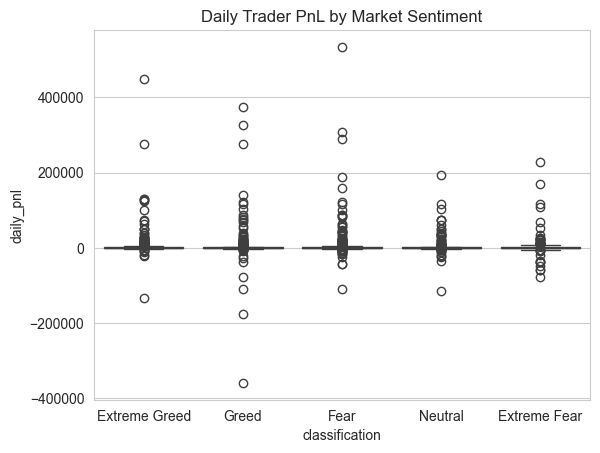

In [15]:
pnl_compare = trader_daily.groupby('classification')['daily_pnl'].mean()
print(pnl_compare)

sns.boxplot(x='classification', y='daily_pnl', data=trader_daily)
plt.title("Daily Trader PnL by Market Sentiment")
plt.show()

classification
Extreme Fear     0.329659
Extreme Greed    0.386387
Fear             0.364033
Greed            0.343559
Neutral          0.355414
Name: win_rate, dtype: float64


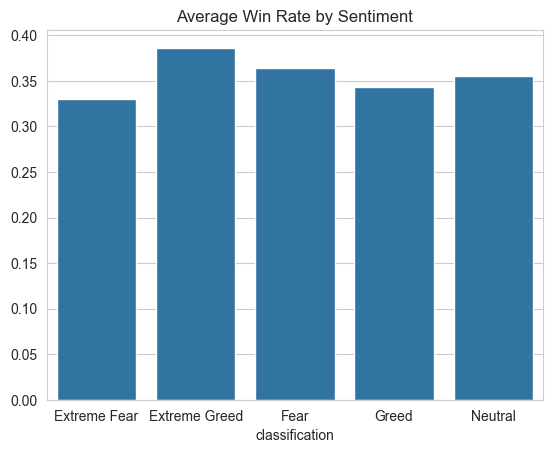

In [16]:
win_compare = trader_daily.groupby('classification')['win_rate'].mean()
print(win_compare)

sns.barplot(x=win_compare.index, y=win_compare.values)
plt.title("Average Win Rate by Sentiment")
plt.show()

classification
Extreme Fear     572.779360
Extreme Greed    271.198880
Fear             274.824489
Greed            258.278371
Neutral          218.625138
Name: pnl_volatility, dtype: float64


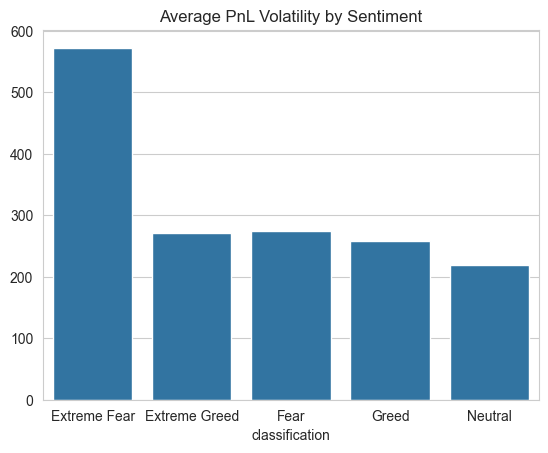

In [17]:
risk_compare = trader_daily.groupby('classification')['pnl_volatility'].mean()
print(risk_compare)

sns.barplot(x=risk_compare.index, y=risk_compare.values)
plt.title("Average PnL Volatility by Sentiment")
plt.show()

classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: total_trades, dtype: float64


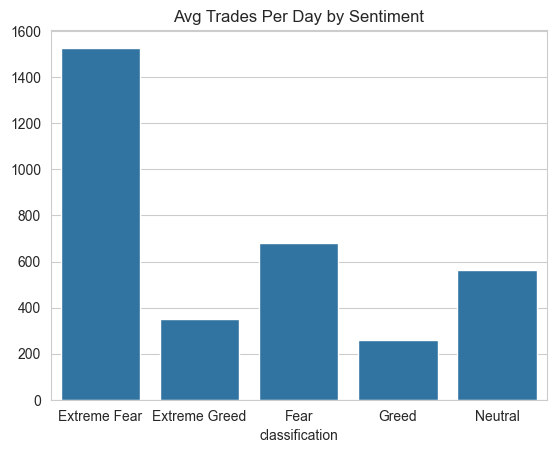

In [18]:
trade_freq = market_daily.groupby('classification')['total_trades'].mean()
print(trade_freq)

sns.barplot(x=trade_freq.index, y=trade_freq.values)
plt.title("Avg Trades Per Day by Sentiment")
plt.show()

classification
Extreme Fear    NaN
Extreme Greed   NaN
Fear            NaN
Greed           NaN
Neutral         NaN
Name: avg_leverage, dtype: float64


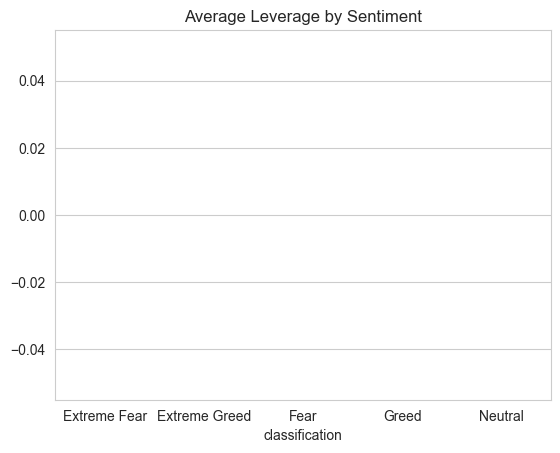

In [19]:
leverage_shift = market_daily.groupby('classification')['avg_leverage'].mean()
print(leverage_shift)

sns.barplot(x=leverage_shift.index, y=leverage_shift.values)
plt.title("Average Leverage by Sentiment")
plt.show()

classification
Extreme Fear     2.394566
Extreme Greed    1.194009
Fear             4.767353
Greed            2.263881
Neutral          3.667791
Name: long_short_ratio, dtype: float64


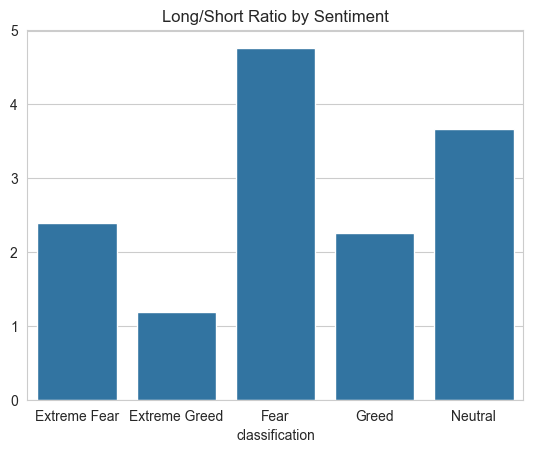

In [20]:
ls_ratio = long_short.groupby('classification')['long_short_ratio'].mean()
print(ls_ratio)

sns.barplot(x=ls_ratio.index, y=ls_ratio.values)
plt.title("Long/Short Ratio by Sentiment")
plt.show()

lev_segment    classification
High Leverage  Extreme Fear      5866.130693
               Extreme Greed     4717.656884
               Fear              5057.905312
               Greed             1445.572959
               Neutral           2208.446242
Low Leverage   Extreme Fear      3133.655866
               Extreme Greed     5652.392043
               Fear              5583.059451
               Greed             5322.243872
               Neutral           4411.040949
Name: daily_pnl, dtype: float64


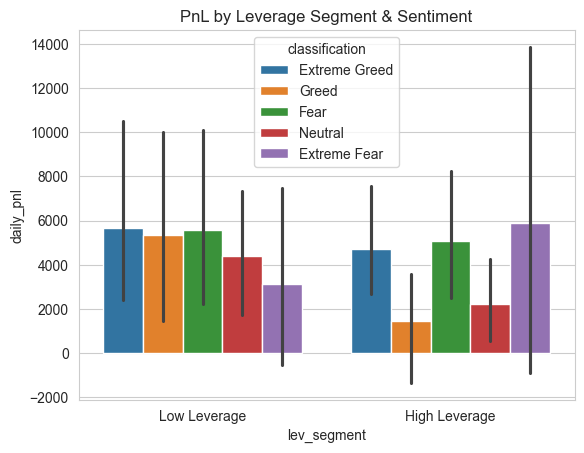

In [21]:
median_lev = trader_daily['avg_leverage'].median()

trader_daily['lev_segment'] = trader_daily['avg_leverage'].apply(
    lambda x: 'High Leverage' if x > median_lev else 'Low Leverage'
)

seg1_perf = trader_daily.groupby(['lev_segment', 'classification'])['daily_pnl'].mean()
print(seg1_perf)

sns.barplot(x='lev_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Leverage Segment & Sentiment")
plt.show()

freq_segment  classification
Frequent      Extreme Fear       6799.753651
              Extreme Greed      8437.437459
              Fear              10311.492505
              Greed              5486.377107
              Neutral            5759.162182
Infrequent    Extreme Fear        457.020275
              Extreme Greed      1627.473851
              Fear                913.034911
              Greed              1401.949513
              Neutral            1118.075454
Name: daily_pnl, dtype: float64


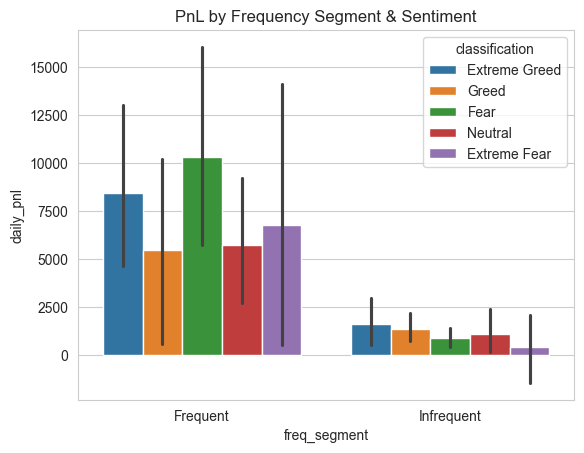

In [22]:
median_trades = trader_daily['trade_count'].median()

trader_daily['freq_segment'] = trader_daily['trade_count'].apply(
    lambda x: 'Frequent' if x > median_trades else 'Infrequent'
)

seg2_perf = trader_daily.groupby(['freq_segment', 'classification'])['daily_pnl'].mean()
print(seg2_perf)

sns.barplot(x='freq_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Frequency Segment & Sentiment")
plt.show()

consistency_segment  classification
Consistent           Extreme Fear      3290.592348
                     Extreme Greed     2162.889841
                     Fear              1353.207397
                     Greed             1678.708402
                     Neutral           1538.349386
Inconsistent         Extreme Fear      5652.986490
                     Extreme Greed     8049.051238
                     Fear              8852.113928
                     Greed             4794.034585
                     Neutral           5183.764214
Name: daily_pnl, dtype: float64


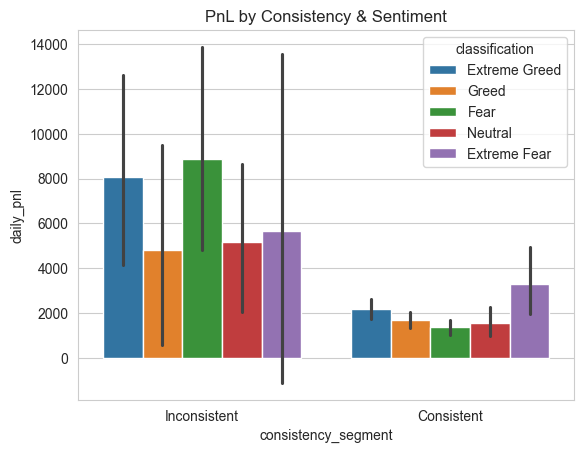

In [23]:
median_consistency = trader_daily['consistency_index'].median()

trader_daily['consistency_segment'] = trader_daily['consistency_index'].apply(
    lambda x: 'Consistent' if x > median_consistency else 'Inconsistent'
)

seg3_perf = trader_daily.groupby(['consistency_segment', 'classification'])['daily_pnl'].mean()
print(seg3_perf)

sns.barplot(x='consistency_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Consistency & Sentiment")
plt.show()